In [8]:
import os
samples = os.listdir('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/samples')
print(len(samples))

3993


In [9]:
%cd '/teamspace/studios/this_studio/sam-hq'
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

/teamspace/studios/this_studio/sam-hq


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
    sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
    model_type = "vit_l"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)


<All keys matched successfully>


In [4]:
    import cv2
    import torch
    image = cv2.imread('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/eastafrica_acactort_2020.05.08.14.52.18_820f49c8-795b-453e-8eb1-7d473669ab84_img_20200507_152251_66198747.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image_size = image.shape[:2]
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image_torch = torch.as_tensor(image, device=device)
    '''
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    box = transform.apply_boxes(box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]
    '''
    input_image = sam.preprocess(transformed_image)
    input_size = tuple(transformed_image.shape[-2:])
    print(input_size)

NameError: name 'transformed_image' is not defined

In [11]:
%cd /teamspace/studios/this_studio/Deeplab/
from inference.infer import *
from post_processing.control_random_field import *

/teamspace/studios/this_studio/Deeplab


In [12]:
from torch.nn.functional import threshold, normalize
from scipy.special import expit
def normalize_0_1(tensor):
    """
    Normalizes a tensor to the range [0, 1]
    """
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor
    
def get_prob(img_path, box):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image_size = image.shape[:2]
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image_torch = torch.as_tensor(image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
    box = transform.apply_boxes(box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
    box_torch = box_torch[None, :]
    input_image = sam.preprocess(transformed_image)
    input_size = tuple(transformed_image.shape[-2:])
    with torch.no_grad():
        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        #image_embedding = sam.image_encoder(input_image)
        features, interm_features = sam.image_encoder(input_image)
        low_res_masks, iou_predictions = sam.mask_decoder(
              image_embeddings=features,
              image_pe=sam.prompt_encoder.get_dense_pe(),
              sparse_prompt_embeddings=sparse_embeddings,
              dense_prompt_embeddings=dense_embeddings,
              multimask_output=False,
              hq_token_only = False,
              interm_embeddings = interm_features,
    
            )
        upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

    
    return normalize(threshold(upscaled_masks, 0.0, 0))
    
def get_logits(img_path, box = None):
    predictor.set_image(np.array(flip(Image.open(img_path))))
    #input_box =  box
    masks, scores, logits = predictor.predict(
                point_coords=None,
                point_labels=None,
                box= box[None, :],
                multimask_output=False,
                return_logits = True,
            )
    #print(scores[0]) 
    
    return expit(masks[0])

    

In [8]:
import numpy as np
use = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/eastafrica_acactort_2020.05.08.14.52.18_820f49c8-795b-453e-8eb1-7d473669ab84_img_20200507_152251_66198747.jpg'
box = np.array([0,81,337,511])

In [9]:
prob_distribution = (get_logits(use,box))
print(prob_distribution)

[[7.18600131e-06 5.15484862e-06 2.65259973e-06 ... 2.54811755e-10
  5.78763981e-10 8.72254768e-10]
 [7.28668647e-06 5.20542562e-06 2.65648805e-06 ... 1.25929669e-10
  2.57550953e-10 3.68325676e-10]
 [7.49232231e-06 5.30808256e-06 2.66427719e-06 ... 3.07570844e-11
  5.10019249e-11 6.56761520e-11]
 ...
 [9.84954476e-01 9.87936914e-01 9.92258370e-01 ... 2.43591952e-10
  1.38273171e-10 1.04177965e-10]
 [9.62190747e-01 9.71218884e-01 9.83425558e-01 ... 3.08401638e-10
  1.73233067e-10 1.29833699e-10]
 [9.40712094e-01 9.55871403e-01 9.75827813e-01 ... 3.47010587e-10
  1.93899383e-10 1.44941670e-10]]


In [10]:
#numpy_array = binary_mask.squeeze().cpu().numpy()
#print(numpy_array.shape)
pred = (prob_distribution > 0.5)
from PIL import Image
import matplotlib.pyplot as plt

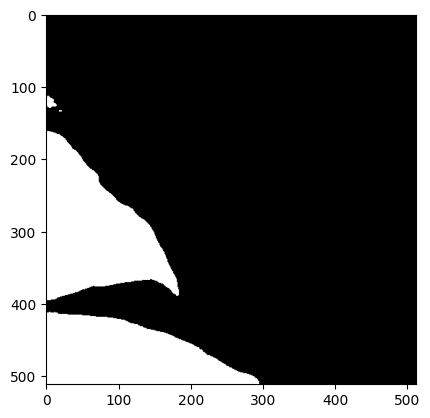

In [11]:
        pred_rgb = np.array(pred*255).astype(np.uint8)
        pred_image = Image.fromarray(pred_rgb).convert('RGB')
        plt.imshow(pred_image)
        plt.show()


In [13]:
os.makedirs('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/probs/')

In [13]:
def get_box_from_deeplab(checkpoint, dataset_path, folder_name = 'probs'):
    os.makedirs(os.path.join(dataset_path,'probs/'), exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_deeplab_model(checkpoint, device).eval()
    sample_dir = os.path.join(dataset_path, 'samples')
    mask_dir = os.path.join(dataset_path, 'binary_masks')
    
    file_list = os.listdir(sample_dir)
    
    for i in tqdm(file_list, desc="Processing images"):
        try:
            img_path = os.path.join(sample_dir, i)
            ext = os.path.basename(img_path).split('.')[-1]
            img_name = os.path.basename(img_path)[:-len(ext) - 1]
            '''
            
            
            mask_path = os.path.join(mask_dir, img_name + '_binarymask.' + ext)
            
            target = get_target(mask_path)
            '''
            img = Image.open(img_path)
            
            img_transform = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            img_tensor = img_transform(img).unsqueeze(0).to(device, dtype=torch.float32)
        
            with torch.no_grad():
                output = model(img_tensor)
                output = torch.squeeze(output, dim=1)
                prob = torch.sigmoid(output).detach()
                pred = (prob > 0.5).long().cpu().numpy()[0]
            prob_np = prob[0].cpu().numpy()
            cleaned_mask = crf_with_prob(np.array(img), (pred * 255).astype(np.uint8), prob_np)
            cleaned_mask_img = Image.fromarray((cleaned_mask * 255).astype(np.uint8))
            #pred_rgb = np.array(pred*255).astype(np.uint8)
            #pred_image = Image.fromarray(pred_rgb).convert('RGB')
            box = masks_to_boxes(pil_to_grayscale_tensor(cleaned_mask_img)).numpy()
            #print(box)
            numpy_array = get_logits(img_path, box)
            np.save(os.path.join(dataset_path,folder_name,img_name) + '_prob.npy', numpy_array)
            #with open(os.path.join(dataset_path,folder_name,img_name) + '_prob.')
        except Exception as e:
            # Print the exception
            print(f"An error occurred: {e}")

            
            

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inhouse_default = '/teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth'

In [18]:
model = load_deeplab_model(inhouse_default, device).eval()

Device: cpu
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth


In [15]:
from torchvision.ops import masks_to_boxes
get_box_from_deeplab(inhouse_default, '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large')

Device: cuda
Resume model from /teamspace/studios/this_studio/Deeplab/saved_models/best_deeplabv3plus_mobilenet_custom_os16_0.7854892764326529.pth


Processing images:  24%|██▍       | 961/3993 [22:11<54:39,  1.08s/it]  

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  24%|██▍       | 973/3993 [22:27<53:27,  1.06s/it]  

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  63%|██████▎   | 2499/3993 [58:02<27:22,  1.10s/it]  

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  64%|██████▍   | 2564/3993 [59:33<26:39,  1.12s/it]

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  72%|███████▏  | 2859/3993 [1:06:29<21:54,  1.16s/it]

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  76%|███████▌  | 3015/3993 [1:10:09<18:48,  1.15s/it]

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  92%|█████████▏| 3687/3993 [1:25:57<05:34,  1.09s/it]

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images:  93%|█████████▎| 3694/3993 [1:26:06<05:25,  1.09s/it]

An error occurred: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


Processing images: 100%|██████████| 3993/3993 [1:33:06<00:00,  1.40s/it]


In [16]:
print(len(os.listdir('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/probs')))

249


In [ ]:
# Deeplab/crf_sam_annotations/probs/eastafrica_acactort_2020.07.08.22.09.02_f64fac11-f5a3-4ed4-97cd-aafaf903a391_img_20100103_072427_1187961410_prob.npy

In [16]:
print(os.path.join('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large','probs/'))

/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/probs/


In [17]:
os.makedirs('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/probs/')

In [16]:
print(len(os.listdir('/teamspace/studios/this_studio/Deeplab/crf_sam_annotations_large/probs')))

3985
